In [28]:
from easyfsl.methods import PrototypicalNetworks
from easyfsl.datasets import CUSTOM
from easyfsl.samplers import TaskSampler
from easyfsl.utils import compute_prototypes

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import timm
import os
from glob import glob
import pandas as pd
from collections import defaultdict
import json
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#  Create Json
- json 파일 명 변경 금지

In [29]:
# # train set
# fsl = defaultdict(list)

# path = 'data/train/*'
# label_list = glob(path)
# label_list.sort(key=lambda x: int(x.split('\\')[-1]))

# for label in label_list :  
#     fsl['class_roots'].append(label)
#     fsl['class_names'].append(label.split('\\')[-1])

# with open('data/train.json', 'w') as f:
#     json.dump(fsl, f, indent=2)

    
# # test set
# fsl = defaultdict(list)

# path = 'data/test/*'
# label_list = glob(path)
# label_list.sort(key=lambda x: int(x.split('\\')[-1]))

# for label in label_list :  
#     fsl['class_roots'].append(label)
#     fsl['class_names'].append(label.split('\\')[-1])
    
# with open('data/test.json', 'w') as f:
#     json.dump(fsl, f, indent=2)

In [2]:
n_way = 5
n_shot = 5
device = "cuda"

In [3]:
class CNN(nn.Module) :
    def __init__(self, name='efficientnet_b0', num_classes=0)  :
        super(CNN, self).__init__()
        
        self.model = timm.create_model(name, pretrained=True, num_classes=num_classes)
        
    def forward(self, x) :
        return self.model(x)
#         return self.model.forward_features(x)

## model

In [4]:
fs_model_path = './submission/fsl_224_effi_b0/2E_model.pt'
convolutional_network = CNN()
few_shot_classifier = PrototypicalNetworks(convolutional_network).to(device)

fsm_checkpoint = torch.load(fs_model_path)
few_shot_classifier.load_state_dict(fsm_checkpoint["model_state_dict"])

<All keys matched successfully>

# Custom Dataset

In [5]:
class CUSTOM_DATASET(Dataset) :
    def __init__(self, root_path, n_way_start=None, n_way_end=None, n_shot=None, transform=None) :
        self.img_list, self.label_list = self.folder_split(root_path, n_way_start, n_way_end, n_shot)
        self.n_way_start = n_way_start
        self.n_way_end = n_way_end
        self.transform = transform

    def __len__(self) :
        assert len(self.img_list) == len(self.label_list), 'Doesn\'t match between img length and label length'
        return len(self.img_list)
    
    def __getitem__(self, idx) :
        img = cv2.imread(self.img_list[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = self.transform(image=img)['image']
        label = torch.tensor(self.label_list[idx], dtype=torch.long ) 
        
        return img, label
    
    def folder_split(self, root_path, n_way_start, n_way_end, n_shot) :
        folders = glob(os.path.join(root_path, "*"))
        folders.sort(key=lambda x: int(x.split('\\')[-1]))
        folders = folders[n_way_start : n_way_end]

        img_list = []
        label_list = []
        for idx, path in enumerate(folders) :
            img_list.extend(glob(os.path.join(path,"*"))[:n_shot])
            label_list.extend([idx] * len(glob(os.path.join(path,"*"))[:n_shot]))
        
        return img_list, label_list

In [6]:
support_path = 'data/train'
transform = A.Compose([
    A.Resize(224, 224),    
    A.Normalize(mean=[0.7427, 0.7151, 0.7084], 
                std=[0.2668, 0.2800, 0.2801]),
    ToTensorV2()
])

### prototypes 생성

In [7]:
few_shot_classifier.eval()
prototypes = np.array([])
for n_way_start in range(0, 50, n_way) :
    n_way_end = n_way_start + n_way
    
    custom_dataset = CUSTOM_DATASET(support_path, n_way_start, n_way_end, n_shot, transform)
    dataloader = DataLoader(custom_dataset, batch_size=(n_way_end-n_way_start) * n_shot)
    sup_img, sup_label = next(iter(dataloader))
    with torch.no_grad() :
        sup_feature = few_shot_classifier.backbone.forward(sup_img.to(device))
        if n_way_start == 0 :
            prototypes = compute_prototypes(sup_feature, sup_label).cpu().detach().numpy()
        else : 
            prototypes = np.concatenate([prototypes, compute_prototypes(sup_feature, sup_label).cpu().detach().numpy()])
#     np.save(f'support_feautres/{n_way_start}_{n_way_end}', prototypes.cpu().detach().numpy()) 

In [8]:
# display(prototypes.shape)
# display(prototypes)

In [9]:
# test_img_path = './data/test/19/1.jpg'
# img = cv2.imread(test_img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = transform(image=img)['image']
# img = img.unsqueeze(0)
# z_query = few_shot_classifier.backbone.forward(img.to(device))
# dists = torch.cdist(z_query, torch.tensor(prototypes).to(device))
# scores = -dists

# # scores = -dists.softmax(-1)
# display(dists)
# display(scores)
# torch.max(scores.detach().data, 1,)

## Test Dataset load

In [10]:
support_path = 'data/test'
transform = A.Compose([
    A.Resize(224, 224),    
    A.Normalize(mean=[0.7427, 0.7151, 0.7084], 
                std=[0.2668, 0.2800, 0.2801]),
    ToTensorV2()
])
# n_way_start = None
# n_way_end = None
batch_size = 16
custom_dataset = CUSTOM_DATASET(support_path, transform=transform)
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

### Inference

In [11]:
few_shot_classifier.eval()
top1_score = 0
top5_score = 0
answers = {'label' : [], 'pred' : []}
for img, label in tqdm(dataloader) :
    with torch.no_grad() :
        z_query = few_shot_classifier.backbone.forward(img.to(device))
        for i in range(0, 50, n_way) :
            # (16, 5)
            dists = torch.cdist(z_query, torch.tensor(prototypes[i : i+n_way]).to(device)).softmax(-1)
            
#             dists = -dists.softmax(-1)
            # step 1
            dist_max = torch.max(-dists.detach().data, 1,)
            dist_max = torch.max(-dists.detach().data, 1,)
            if i == 0 :
                # (1, 16)
                d_val = dist_max.values.reshape(1,-1)
                # (1, 16)
                d_ind = dist_max.indices.reshape(1,-1)
        
                
            else : 
                d_val = torch.cat([d_val, dist_max.values.reshape(1,-1)], dim=0)
                d_ind = torch.cat([d_ind, dist_max.indices .reshape(1,-1)], dim=0)
                
        # step 2
        d_val_max = torch.max(d_val, 0)
        d_val_max_val = d_val_max.values
        d_val_max_ind = d_val_max.indices

        # top 5 each image in batch 
        top5_val = d_val.sort(descending=True, dim=0).values[:5]
        top5_ind = d_val.sort(descending=True, dim=0).indices[:5]
        
        # Top 5 label parsing
        top5_list = np.array([])
        for i in range(5) :
            batch_list = np.array([])
            for batch_ind in range(img.shape[0]) :
                row = top5_ind[i][batch_ind].cpu().detach().numpy()
                batch_list = np.append(batch_list, row * n_way + d_ind[row][batch_ind].cpu().detach().numpy() )

            top5_list = np.append(top5_list, batch_list)

        # top 5 each label in batch 
        top5_list = np.transpose(top5_list.reshape(len(top5_list)//img.shape[0], img.shape[0]),(1,0))
        
        # calculate accuracy
        answer = np.array([])
        for i in range(label.shape[0]) :
            row = d_val_max_ind[i].cpu().detach().numpy()
            answer = np.append(answer, row * n_way + d_ind[row][i].cpu().detach().numpy())
            
            # top 5 score
            if label[i].cpu().detach().numpy() in top5_list[i] :
                top5_score += 1
                
        # top 1 score
        top1_score += sum(answer == label.cpu().detach().numpy())
        
        
        answers['label'].extend(label.cpu().detach().numpy())
        answers['pred'].extend(answer.reshape(1,-1)[0])

100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:39<00:00,  5.97it/s]


### Accuracy
- mini-ImageNet 기준 정확도 62 ~ 66 사이임을 가만하면 그렇게 낮은 수치는 아닌듯함
    - refer : A CLOSER LOOK AT FEW-SHOT CLASSIFICATION(https://arxiv.org/pdf/1904.04232.pdf)

In [12]:
print("Top - 1 Accuracy : ",top1_score/(len(dataloader) * batch_size))
print("Top - 5 Accuracy : ",top5_score/(len(dataloader) * batch_size))

Top - 1 Accuracy :  0.5212765957446809
Top - 5 Accuracy :  0.8188829787234042


# class 별 오답률

In [13]:
wrong_cnt = [0] * 50
label_cnt = np.unique(answers['label'], axis=0, return_counts=True)[1]
for pr, la in zip(answers['pred'], answers['label']) :
    if la != int(pr) :
        wrong_cnt[la] += 1

In [14]:
wrong_rate = [0] * len(wrong_cnt)
for idx, (wc, cnt) in enumerate(zip(wrong_cnt, label_cnt)) : 
    print(str(idx) + ' class : ' + str(wc) + " / " +str(cnt) + " => " + str(round((cnt - wc) / cnt, 4)))
    wrong_rate[idx] += (cnt - wc) / cnt

0 class : 21 / 25 => 0.16
1 class : 14 / 24 => 0.4167
2 class : 12 / 31 => 0.6129
3 class : 13 / 41 => 0.6829
4 class : 23 / 47 => 0.5106
5 class : 5 / 51 => 0.902
6 class : 33 / 47 => 0.2979
7 class : 33 / 54 => 0.3889
8 class : 35 / 65 => 0.4615
9 class : 19 / 66 => 0.7121
10 class : 56 / 68 => 0.1765
11 class : 38 / 70 => 0.4571
12 class : 39 / 75 => 0.48
13 class : 46 / 71 => 0.3521
14 class : 42 / 79 => 0.4684
15 class : 11 / 73 => 0.8493
16 class : 37 / 72 => 0.4861
17 class : 64 / 75 => 0.1467
18 class : 28 / 76 => 0.6316
19 class : 25 / 81 => 0.6914
20 class : 43 / 78 => 0.4487
21 class : 12 / 77 => 0.8442
22 class : 23 / 80 => 0.7125
23 class : 64 / 80 => 0.2
24 class : 19 / 82 => 0.7683
25 class : 55 / 81 => 0.321
26 class : 70 / 82 => 0.1463
27 class : 43 / 84 => 0.4881
28 class : 38 / 85 => 0.5529
29 class : 23 / 84 => 0.7262
30 class : 31 / 85 => 0.6353
31 class : 18 / 81 => 0.7778
32 class : 45 / 84 => 0.4643
33 class : 19 / 82 => 0.7683
34 class : 26 / 87 => 0.7011
35 cl

In [15]:
idx = np.argmin(wrong_rate)
print("가장 낮은 점수 : ", round(wrong_rate[idx],4), "//",idx,"class")
idx = np.argmax(wrong_rate)
print("가장 높은 점수 : ", round(wrong_rate[idx],4), "//",idx,"class")

가장 낮은 점수 :  0.1463 // 26 class
가장 높은 점수 :  0.9667 // 47 class


# class 별 가장 많이 예측된 값

### Top - 5 값 출력

In [16]:
top_num = 5

answers['pred'] = list(map(int, answers['pred']))
df_answer = pd.DataFrame(answers)

# # label = 0 일 때 model이 예측한 값들, 30 class가 5개로 가장 많음
for i in range(len(df_answer['label'].unique())) :
    print(f"==== {i} class ====")
    display(df_answer['pred'][df_answer['label'] == i].value_counts().sort_values()[-top_num - 1:])

==== 0 class ====


31    2
23    3
43    3
36    4
0     4
30    5
Name: pred, dtype: int64

==== 1 class ====


30     1
16     1
42     2
32     3
4      7
1     10
Name: pred, dtype: int64

==== 2 class ====


21     1
5      1
29     2
38     3
12     4
2     19
Name: pred, dtype: int64

==== 3 class ====


20     4
16     9
3     28
Name: pred, dtype: int64

==== 4 class ====


42     1
41     2
32     3
16     3
1     12
4     24
Name: pred, dtype: int64

==== 5 class ====


49     1
2      2
34     2
5     46
Name: pred, dtype: int64

==== 6 class ====


44     1
11     1
31     1
35     2
6     14
36    27
Name: pred, dtype: int64

==== 7 class ====


40     2
24     2
11     3
36     6
43    15
7     21
Name: pred, dtype: int64

==== 8 class ====


6      2
32     2
40     4
24    13
18    14
8     30
Name: pred, dtype: int64

==== 9 class ====


20     1
42     1
37     2
3      6
35     6
9     47
Name: pred, dtype: int64

==== 10 class ====


2      2
36     4
32     6
39     9
10    12
40    22
Name: pred, dtype: int64

==== 11 class ====


44     1
43     2
23     4
36    12
30    15
11    32
Name: pred, dtype: int64

==== 12 class ====


9      3
35     5
4      5
3      7
42    11
12    36
Name: pred, dtype: int64

==== 13 class ====


18     3
35     4
8      6
40     7
32     7
13    25
Name: pred, dtype: int64

==== 14 class ====


0      1
11     2
32     2
40     6
39    30
14    37
Name: pred, dtype: int64

==== 15 class ====


30     1
5      1
28     1
36     2
12     3
15    62
Name: pred, dtype: int64

==== 16 class ====


37     1
42     3
20    11
3     22
16    35
Name: pred, dtype: int64

==== 17 class ====


49     2
28     2
38     3
35     5
17    11
12    46
Name: pred, dtype: int64

==== 18 class ====


2      1
10     1
8      3
6      3
24    18
18    48
Name: pred, dtype: int64

==== 19 class ====


2      1
30     1
38     1
43    10
36    11
19    56
Name: pred, dtype: int64

==== 20 class ====


48     1
16    12
3     30
20    35
Name: pred, dtype: int64

==== 21 class ====


28     1
30     1
35     2
3      2
33     2
21    65
Name: pred, dtype: int64

==== 22 class ====


20     1
12     1
35     4
3      8
9      9
22    57
Name: pred, dtype: int64

==== 23 class ====


31     2
36     6
11    11
23    16
30    20
0     21
Name: pred, dtype: int64

==== 24 class ====


44     1
40     1
49     2
38     2
18    10
24    63
Name: pred, dtype: int64

==== 25 class ====


2      3
3      3
17     3
35     7
28    19
25    26
Name: pred, dtype: int64

==== 26 class ====


43     2
0      2
30     8
26    12
36    26
11    29
Name: pred, dtype: int64

==== 27 class ====


35     1
16     6
3      8
48    10
41    13
27    41
Name: pred, dtype: int64

==== 28 class ====


20     2
42     2
2      2
46     6
25    13
28    47
Name: pred, dtype: int64

==== 29 class ====


7      1
24     1
31     2
30     4
38    13
29    61
Name: pred, dtype: int64

==== 30 class ====


9      1
23     2
31     2
36     9
11    15
30    54
Name: pred, dtype: int64

==== 31 class ====


29     2
30     3
36     3
38     4
44     5
31    63
Name: pred, dtype: int64

==== 32 class ====


10     4
49     5
36     6
40     8
39     8
32    39
Name: pred, dtype: int64

==== 33 class ====


44     1
35     1
19     1
32     2
40     5
33    63
Name: pred, dtype: int64

==== 34 class ====


38     2
12     4
2      8
46    12
34    61
Name: pred, dtype: int64

==== 35 class ====


22     5
37     7
3     11
12    15
9     16
35    22
Name: pred, dtype: int64

==== 36 class ====


6      3
7      3
0      4
11     4
30     9
36    58
Name: pred, dtype: int64

==== 37 class ====


3      3
25     4
27     4
9      6
12    13
37    48
Name: pred, dtype: int64

==== 38 class ====


10     3
12     3
29     5
13     6
21    10
38    39
Name: pred, dtype: int64

==== 39 class ====


11     3
36     3
40     8
32    10
14    20
39    38
Name: pred, dtype: int64

==== 40 class ====


34     1
18     2
14     3
32     5
39     9
40    62
Name: pred, dtype: int64

==== 41 class ====


48     6
3      7
1      7
27    12
32    15
41    29
Name: pred, dtype: int64

==== 42 class ====


16     2
1      5
3      7
4     11
12    13
42    44
Name: pred, dtype: int64

==== 43 class ====


10     2
7      4
35     7
36    12
19    15
43    39
Name: pred, dtype: int64

==== 44 class ====


7      1
10     2
30     3
43     6
31     6
44    70
Name: pred, dtype: int64

==== 45 class ====


2      3
38     4
21     7
28     8
12    15
45    34
Name: pred, dtype: int64

==== 46 class ====


35     2
34     4
38     5
27     5
12    22
46    38
Name: pred, dtype: int64

==== 47 class ====


24     1
6      2
47    87
Name: pred, dtype: int64

==== 48 class ====


1      6
27     6
3      6
41     9
16    18
48    27
Name: pred, dtype: int64

==== 49 class ====


13     5
21     5
24    10
40    10
32    13
49    25
Name: pred, dtype: int64

### 사진 별 비교

In [17]:
def load_imgs(path) :
    label_list = glob(path)
    label_list.sort(key=lambda x: int(x.split('\\')[-1]))
    sample_imgs = []
    for label in label_list :
        img = cv2.imread(os.path.join(label, os.listdir(label)[0]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        sample_imgs.append(img)
    return sample_imgs

In [18]:
ori_img = load_imgs('data/train/*')
top_k_img = load_imgs('data/test/*')
none_img = np.zeros((224,224,3))

C:\Users\quhb2\AppData\Local\Temp\ipykernel_3032\3332566778.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,top_num+1,figsize=(15,3))


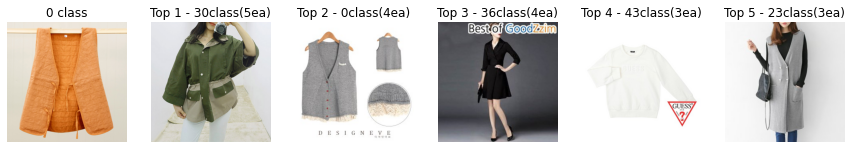

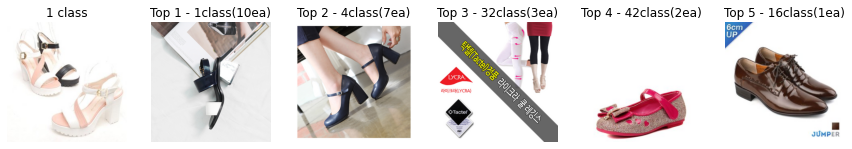

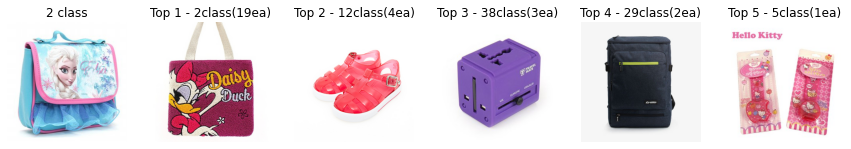

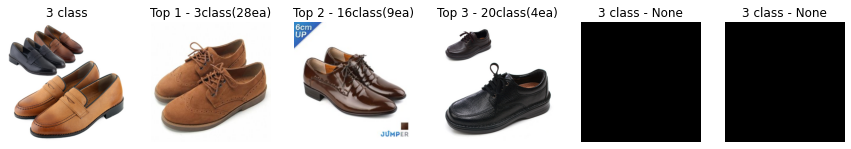

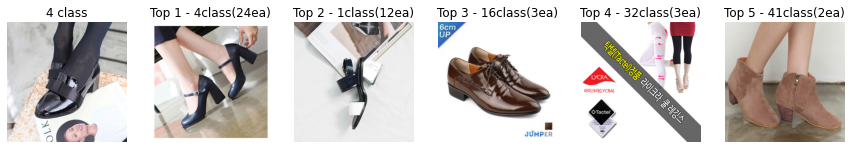

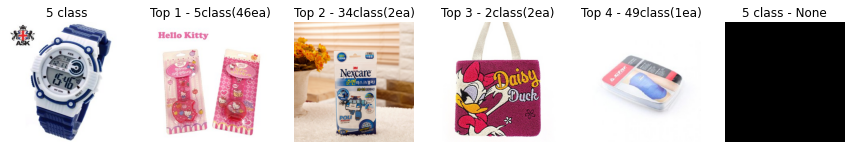

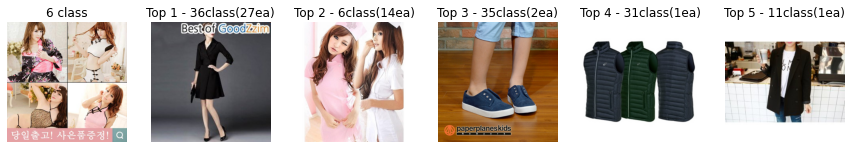

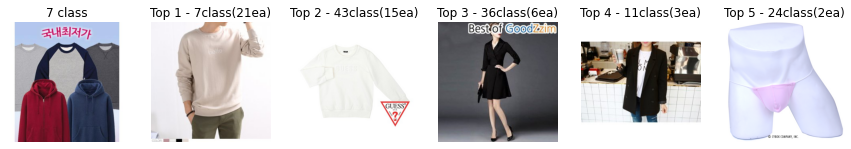

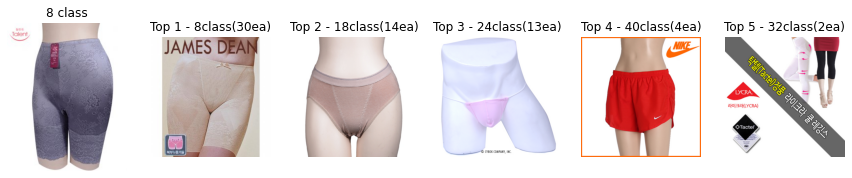

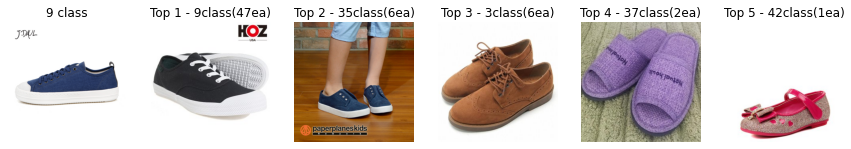

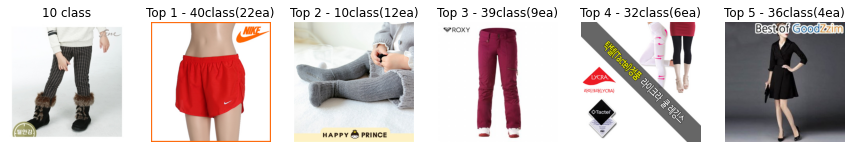

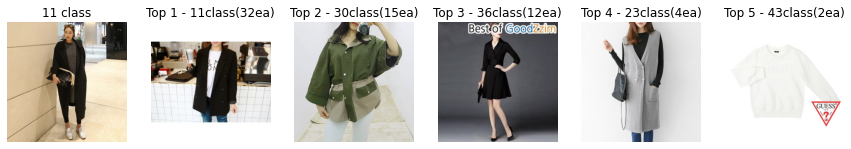

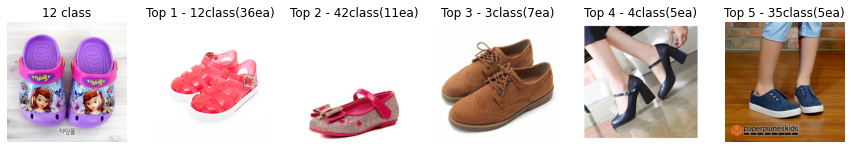

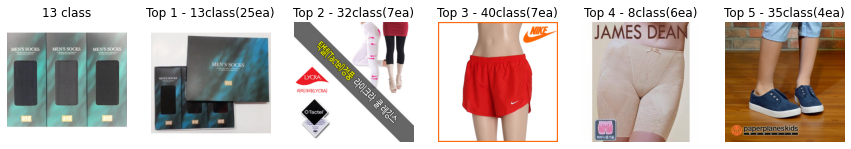

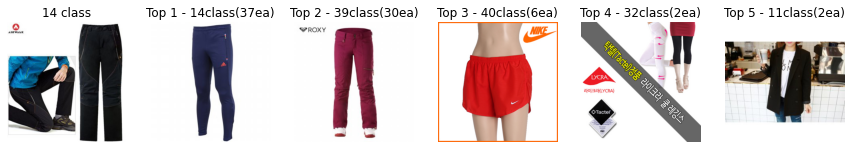

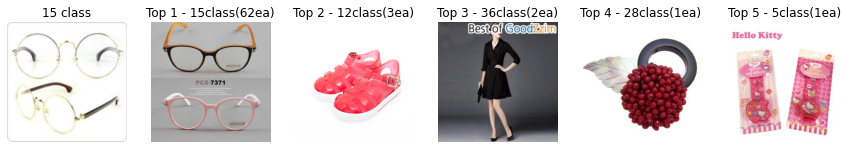

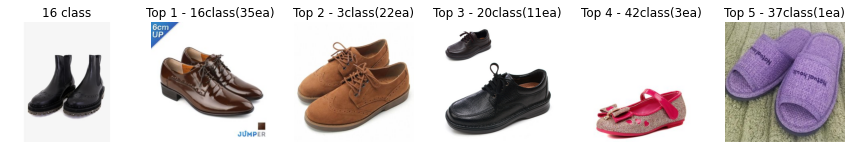

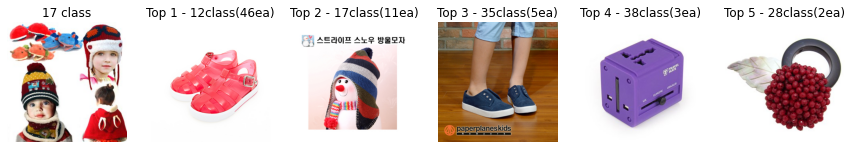

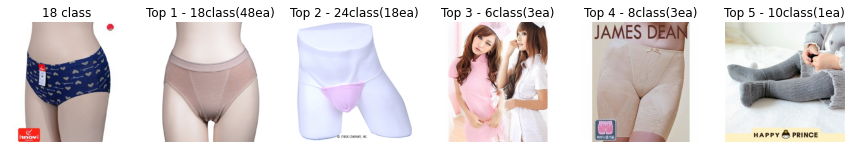

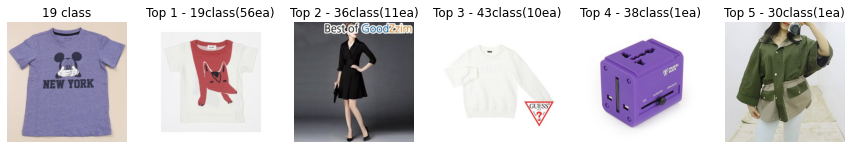

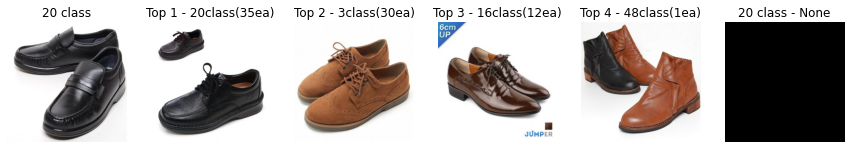

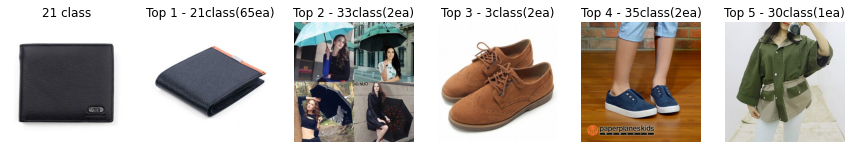

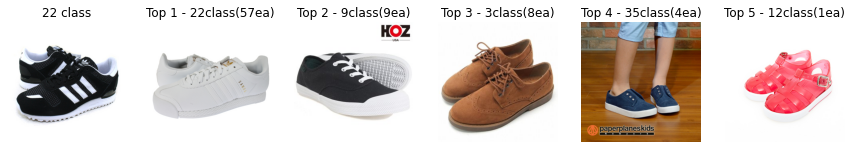

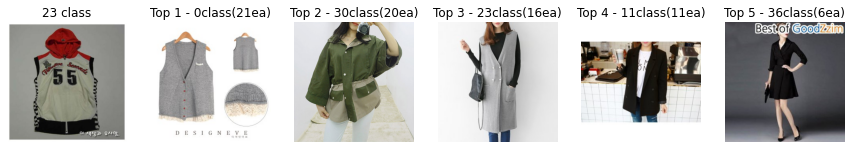

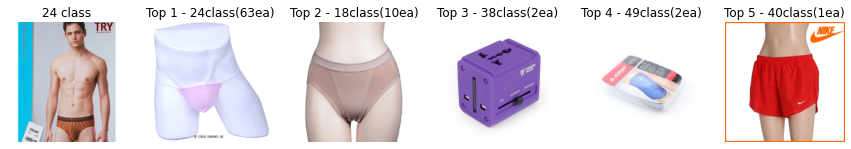

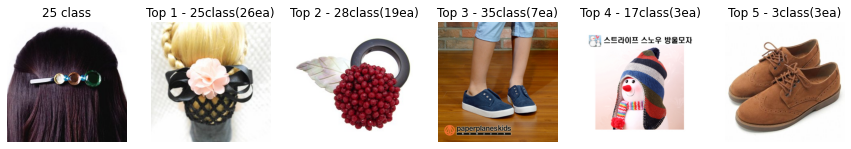

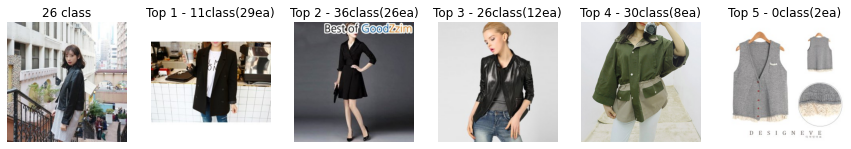

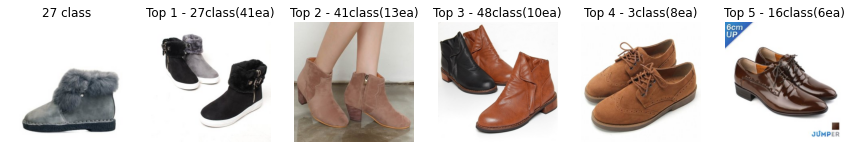

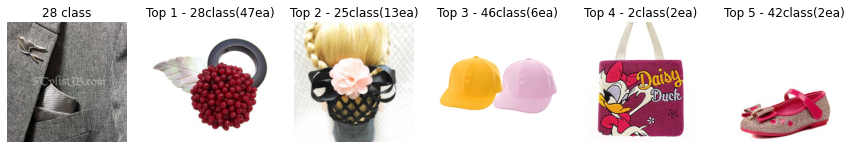

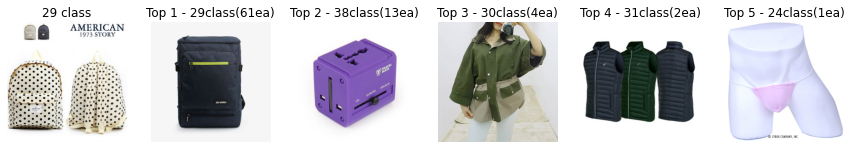

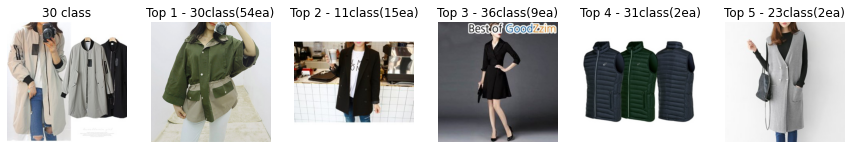

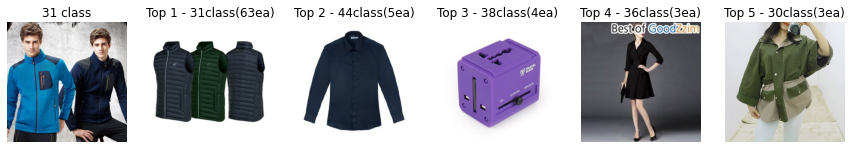

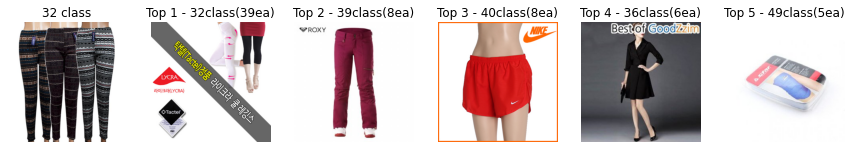

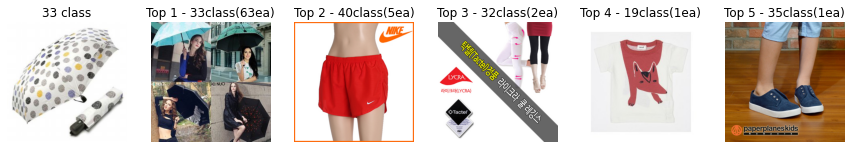

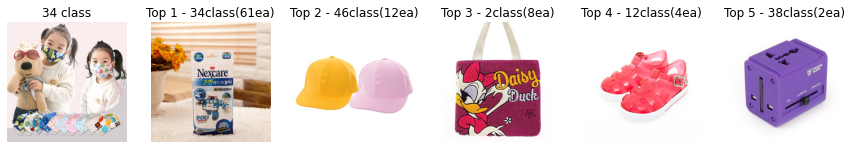

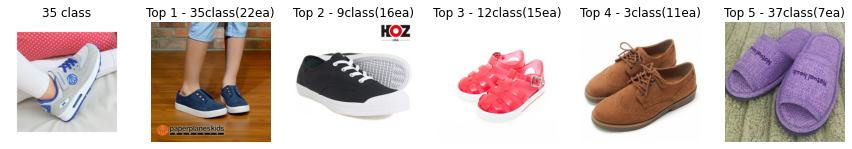

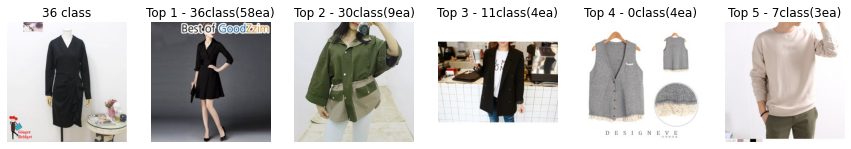

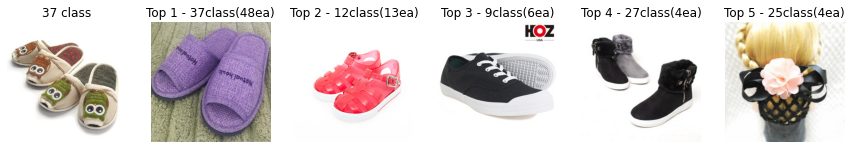

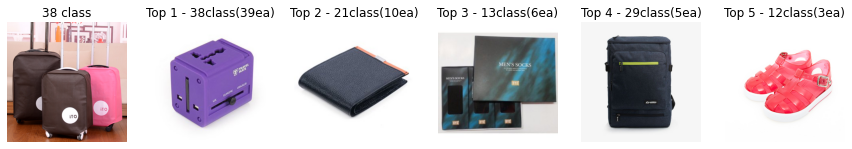

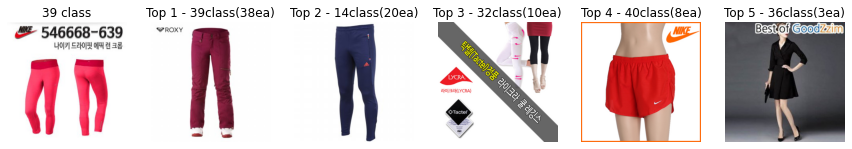

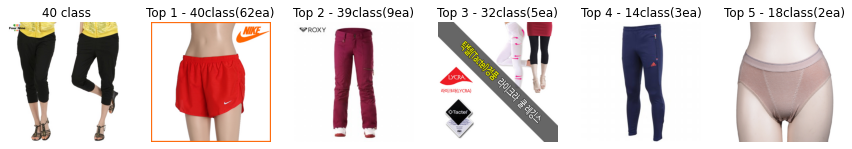

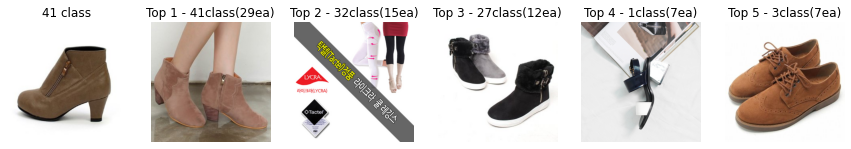

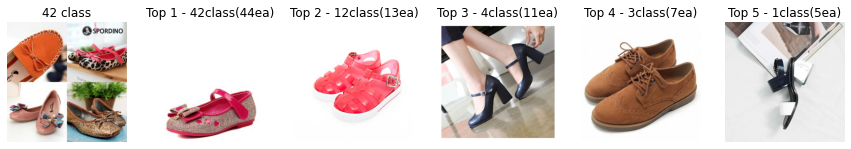

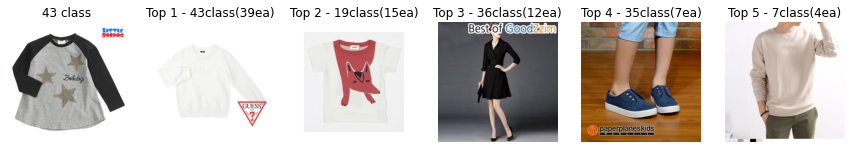

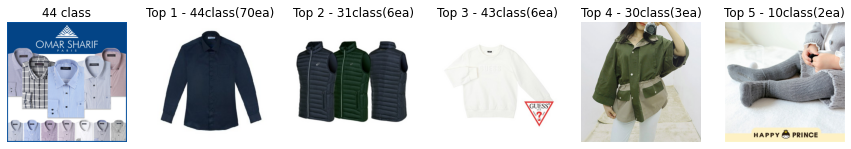

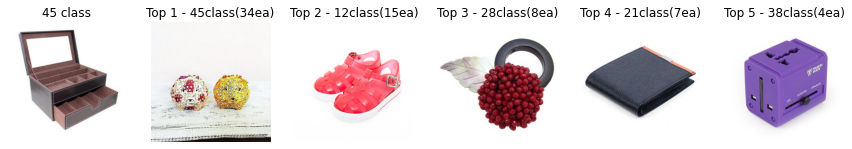

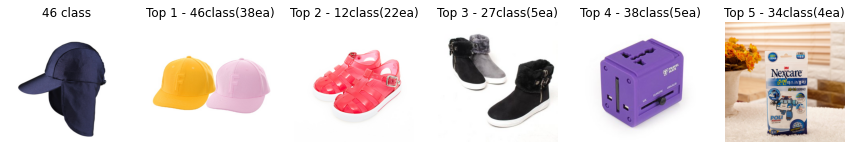

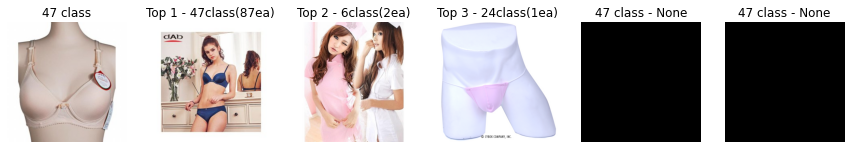

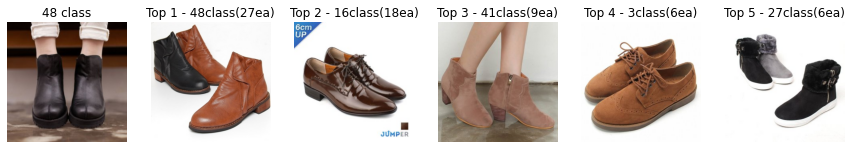

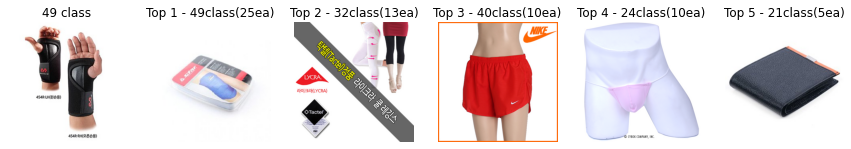

In [19]:
topK_list = []
for i in range(len(df_answer['label'].unique())):
#     topk = df_answer['pred'][df_answer['label'] == i].value_counts()[-top_num - 1:]
    topk = df_answer['pred'][df_answer['label'] == i].value_counts().sort_values()[-top_num - 1:]
    topk_class = list(topk.keys())
    topk_class.reverse()
    topK_list.append(topk_class)
    
    topk_value = list(topk.values)
    topk_value.reverse()

    fig, axs = plt.subplots(1,top_num+1,figsize=(15,3))
    axs = axs.flatten()
    for idx, x in enumerate(axs) :
        if idx == 0 :
            x.set_title(f'{i} class')
            x.set_axis_off()
            x.imshow(ori_img[i])
        else : 
            try :
                x.set_title(f'Top {idx} - {topk_class[idx-1]}class({topk_value[idx-1]}ea)')
                x.set_axis_off()
                x.imshow(top_k_img[topk_class[idx-1]])
            except :
                x.set_title(f'{i} class - None')
                x.set_axis_off()
                x.imshow(none_img)
    
plt.show()# 6

In [20]:
# # 각 class 별 top k class list
topK_list

[[30, 0, 36, 43, 23, 31],
 [1, 4, 32, 42, 16, 30],
 [2, 12, 38, 29, 5, 21],
 [3, 16, 20],
 [4, 1, 16, 32, 41, 42],
 [5, 34, 2, 49],
 [36, 6, 35, 31, 11, 44],
 [7, 43, 36, 11, 24, 40],
 [8, 18, 24, 40, 32, 6],
 [9, 35, 3, 37, 42, 20],
 [40, 10, 39, 32, 36, 2],
 [11, 30, 36, 23, 43, 44],
 [12, 42, 3, 4, 35, 9],
 [13, 32, 40, 8, 35, 18],
 [14, 39, 40, 32, 11, 0],
 [15, 12, 36, 28, 5, 30],
 [16, 3, 20, 42, 37],
 [12, 17, 35, 38, 28, 49],
 [18, 24, 6, 8, 10, 2],
 [19, 36, 43, 38, 30, 2],
 [20, 3, 16, 48],
 [21, 33, 3, 35, 30, 28],
 [22, 9, 3, 35, 12, 20],
 [0, 30, 23, 11, 36, 31],
 [24, 18, 38, 49, 40, 44],
 [25, 28, 35, 17, 3, 2],
 [11, 36, 26, 30, 0, 43],
 [27, 41, 48, 3, 16, 35],
 [28, 25, 46, 2, 42, 20],
 [29, 38, 30, 31, 24, 7],
 [30, 11, 36, 31, 23, 9],
 [31, 44, 38, 36, 30, 29],
 [32, 39, 40, 36, 49, 10],
 [33, 40, 32, 19, 35, 44],
 [34, 46, 2, 12, 38],
 [35, 9, 12, 3, 37, 22],
 [36, 30, 11, 0, 7, 6],
 [37, 12, 9, 27, 25, 3],
 [38, 21, 13, 29, 12, 10],
 [39, 14, 32, 40, 36, 11],
 [40

## === 표시한 부분이 잘 안되는 부분
#### 총평
- 0 - 상의는 상의끼리 잘 묶임, 원피스나, 겉 옷도 포함 됨
- 1 - 하이힐과 구두가 묶임
- 2 - 가방은 가방 끼리 잘 묶임, 신발이나 모자도 포함됨
- 3 - 남성 구두는 남성 구두끼리 잘 묶임
- 4 - 여성 구두는 여성 구두와 남성 구두가 묶임
- 5 - 시계는 시계끼리 묶임
- 6 - ==== 란제리 코스튬은 안 묶임 ====
- 7 - 상의는 상의끼리 잘 묶임, 겉 옷도 포함됨
- 8 - 속바지는 속옷류 그리고 짧은 반바지와 묶임
- 9 - 스니커즈는 스니커즈, 구두, 슬리퍼등과 묶임
- 10 - ==== 어린이 속옷은 반바지, 속옷류와 묶임 ===== 
- 11 - 긴 겉 옷은 겉 옷끼리 묶임
- 12 - 어린이 슬리퍼는 신발류 끼리 묶임
- 13 - 양말은 양말과 속옷으로 묶임
- 14 - 남성 용 긴 트레이닝 바지는 여성용 긴 바지와 묶임
- 15 - 안경은 안경끼리 잘 묶임
- 16 - 구두는 구두류 끼리 잘 묶임
- 17 - ==== 어린이 빵모자는 슬리퍼와 묶임 =====
- 18 - 여성 속옷은 속옷류 끼리 잘 묵임 
- 19 - 어린이 반팔티는 윗 옷끼리 묶임
- 20 - 구두는 구두끼리 묶임
- 21 - 지갑은 지갑끼리 묶임
- 22 - 운동화는 운동화끼리, 신발류로 묶임
- 23 - 민소매 긴 겉옷은 겉 옷끼리 묶임
- 24 - 남성 속옷은 속옷류 끼리 묶임
- 25 - 악세사리는 악세사리로 묶임
- 26 - 겉 옷은 원피스, 겉 옷 끼리 묵임
- 27 - 어그 부츠는 신발류로 묶임
- 28 - 악세사리는 악세사리류로 묶임
- 29 - 백팩은 가방류끼리 묶임
- 30 - 겉 옷은 겉옷끼리 묶임
- 31 - 등산용 조끼?는 겉옷류 끼리 잘 묶임
- 32 - 레깅스는 레깅스류와 긴바지로 묶임
- 33 - 우산은 우산끼리 묶임
- 34 - 아동용 마스크는 마스크와 모자로 묶임
- 35 - 아동용 운동화는 신발류 끼리 묶임
- 36 - 원피스는 원피스끼리 묶임
- 37 - 실내 슬리퍼는 신발류끼리 묶임
- 38 - 케리어는 케리어끼리 묶임
- 39 - 긴 바지는 긴바지류로 묶임
- 40 - 반바지는 반바지끼리 잘 묶임
- 41 - 구두는 신발류끼리 묶임
- 42 - 단화는 단화와 슬리퍼 끼리 묶임
- 43 - 아동용 긴팔 옷은 아동용 반팔 옷과 묶임
- 44 - 셔츠는 셔츠와 긴팔, 조끼 등으로 묶임
- 45 - ==== 수납장은 수납장과 슬리퍼 끼리 묶임 =====
- 46 - 모자는 모자와 슬리퍼랑 묶임
- 47 - 여성용 속옷은 속옷끼리 잘 묶임
- 48 - 구두는 구두와 신발류끼리 묶임
- 49 - ==== 보호대는 보호대와 레깅스류로 묶임 ======
